In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
%%writefile ../src/full_agent.py

"""This code contains the code for the logistician agent"""

import os
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from src.supervisor_schema import AgentInputState
from src.supervisor_agent import DelegateNextAgent, clarify_with_user, supervisor_agent, supervisor_tools
from src.logistics_agent import LogisticsAgent , LogisticsState

# Build the scoping workflow
full_agent_builder = StateGraph(LogisticsState, input_schema=AgentInputState)

# Add workflow nodes
full_agent_builder.add_node("supervisor_agent", supervisor_agent)
full_agent_builder.add_node("supervisor_tools", supervisor_tools)
full_agent_builder.add_node("clarify_with_user", clarify_with_user)
full_agent_builder.add_node("LogisticsAgent", LogisticsAgent)

# Add workflow edges
full_agent_builder.add_edge(START, "supervisor_agent")
full_agent_builder.add_conditional_edges(
    "supervisor_agent",
     DelegateNextAgent,
    {
        "supervisor_tools"  : "supervisor_tools", 
        "clarify_with_user" : "clarify_with_user", 
        "logistics_agent"   : "LogisticsAgent"
    },
)
full_agent_builder.add_edge("supervisor_tools", "supervisor_agent")
full_agent_builder.add_edge("clarify_with_user", END)

# Compile the workflow
checkpointer = InMemorySaver()
full_agent = full_agent_builder.compile(checkpointer = checkpointer)

Overwriting ../src/full_agent.py


c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


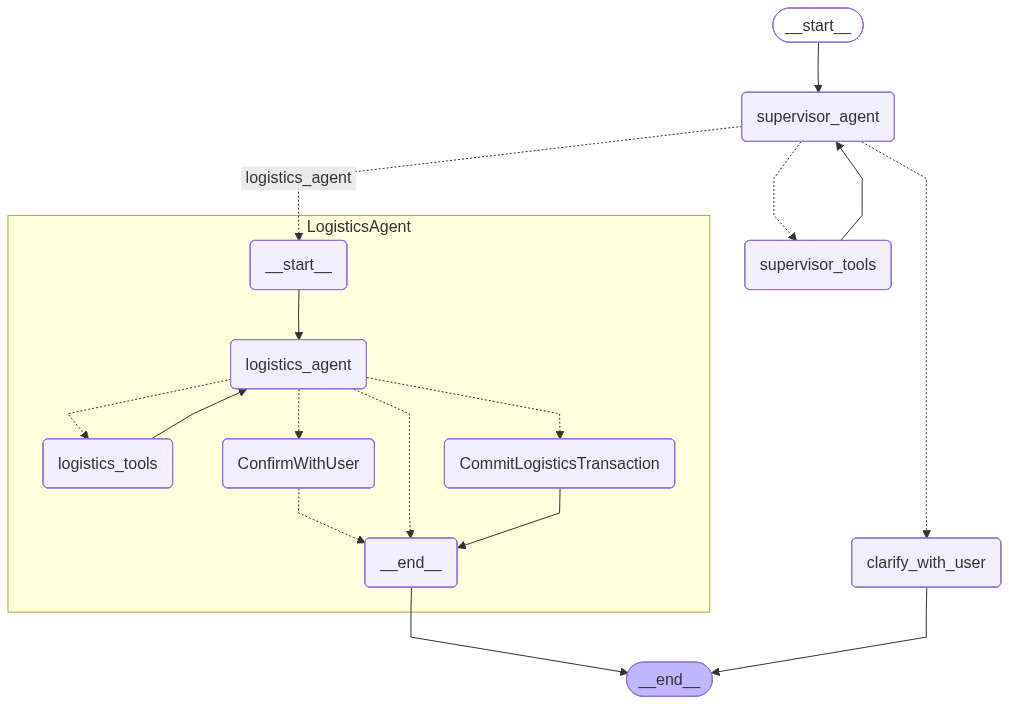

In [4]:
from IPython.display import Image, display
from src.full_agent import full_agent

# Show the agent
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

In [5]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.full_agent import full_agent

thread = {"configurable":{"thread_id":"1"}}
result = await full_agent.ainvoke({"messages":[HumanMessage(content="I want to enter the AWB/BL 12345")]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to enter the AWB/BL 12345                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The user has provided the AWB/BL number as 12345. This field is required and relates to the Logistics           │
│ Department. Assigning this task to the Logistics Agent for further handling.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Information**                                                                              │
│                                                                                                                 │
│ I cannot proceed with your logistics request because the following required field is missing:                   │
│                                                                                                                 │
│ - **Shipment_Mode**                                                                                             │
│                                                                                                                 │
│ **What to do next:**                                                                                            │
│ Please provide the missing information in your reply. For example:                                              │
│ `Shipment_Mode: Air freight`                                                                                    │
│                                                                                                                 │
│ If you need help or clarification about this field, just let me know!                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯